# Alpha Feature Selector for Time Series Data

## Introduction

`alpha_Feat_Selector` is a Python function designed for effective feature selection in time series data. It combines several statistical methods and machine learning techniques to identify the most significant features for time series forecasting models.

## Features

- **Lag Feature Creation**: Generates lagged versions of the target variable to capture temporal dependencies.
- **Rolling Window Statistics**: Computes rolling statistics like mean and standard deviation as potential features.
- **Time Series Decomposition**: Extracts trend, seasonality, and residuals from the time series.
- **Feature Importance Analysis**: Uses Random Forest to determine the importance of each feature.
- **Visualization Dashboard**: Provides insightful visualizations for time series analysis and feature importance.

## Prerequisites

Ensure you have the following libraries installed:
- pandas
- numpy
- matplotlib
- seaborn
- sklearn
- statsmodels
- tqdm

You can install them using pip:

```bash
pip install pandas numpy matplotlib seaborn sklearn statsmodels tqdm
```

## Usage

Here's how to use the alpha_Feat_Selector function:

Import the Function:
Ensure the alpha_Feat_Selector function is in your Python path.

Prepare Your Data:
Load your time series data into a Pandas DataFrame.

Run the Feature Selector:
Call the alpha_Feat_Selector function with your DataFrame, the name of the file where you want to save the processed data, and the name of the target column.

Example:

```bash
df_clean, features_selected, analysis_explanation = alpha_Feat_Selector(your_dataframe, 'processed_data.csv', 'your_target_column', 'importance_percentile')

df_clean, features_selected, analysis_explanation = alpha_Feat_Selector(df_raw, 'cleaned_data.csv', 'Close', importance_percentile=70)
```

## View the Results:
The function returns a cleaned DataFrame and displays a dashboard of visualizations.


## Example

Here's a simple example of using alpha_Feat_Selector:

```bash

import pandas as pd
# Load your data
df = pd.read_csv('your_time_series_data.csv')

# Assuming 'Close' is your target column
df_clean = alpha_Feat_Selector(df, 'cleaned_data.csv', 'Close')

```
## Conclusion

The alpha_Feat_Selector function is a comprehensive tool for feature selection in time series data, making the process more intuitive and effective. It's suitable for both beginners and experienced practitioners in the field of time series analysis.


#### Load Dataframe from csv file 

In [53]:
import pandas as pd
import numpy as np

# Create raw df to be used for testing purposes
# Load a csv file with the raw data 

df_raw = pd.read_csv("BTCUSDT_06_01_2024_1h_raw.csv")

#### Inspect Data 

In [54]:
print(df_raw.head(1))
print(df_raw.columns)

              dateTime       LTime       OpenTime      Open     High  \
0  2018-01-01 22:00:00  1514844000  1514844000000  13494.99  13599.7   

        Low    Close      Volume      CloseTime  QuoteAssetVolume  ...  \
0  13450.96  13452.0  303.301385  1514847599999      4.101907e+06  ...   

      lag_3  rolling_mean  rolling_std  day_of_week  hour_of_day        RSI  \
0  13240.37      13249.66    198.14436            0           22  48.561459   

   Smooth_Close  Number  High_Trendline  Low_Trendline  
0  13365.347105      30    15740.326965   15319.874754  

[1 rows x 31 columns]
Index(['dateTime', 'LTime', 'OpenTime', 'Open', 'High', 'Low', 'Close',
       'Volume', 'CloseTime', 'QuoteAssetVolume', 'NumberOfTrades',
       'TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'MA_7', 'MA_30', 'EMA12',
       'EMA26', 'MACD', 'Signal_Line', 'lag_1', 'lag_2', 'lag_3',
       'rolling_mean', 'rolling_std', 'day_of_week', 'hour_of_day', 'RSI',
       'Smooth_Close', 'Number', 'High_Trendline', 

#### Install dependency in case your env not have them already

In [ ]:
# !pip install feature_engine seaborn tqdm sklearn matplotlib statsmodels

#### The function alpha_Feat_Selector is a function that will help you in the feature selection 
I added a loading bar beacuse on very large dataset it may take quirte long. 

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures
from tqdm.notebook import tqdm
import sys
import re

def is_datetime_column(col):
    if pd.api.types.is_string_dtype(col):
        first_non_null = col.dropna().iloc[0] if not col.dropna().empty else ''
        return bool(re.search(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', first_non_null))
    return False

def explain_results(df_clean, features_selected, feature_importances):
    explanation = "Time Series Feature Selection Analysis:\n"
    explanation += "---------------------------------------\n\n"

    explanation += f"Total Features Selected: {len(features_selected)}\n\n"
    for feature in features_selected:
        importance = feature_importances[feature]
        explanation += f"Feature: {feature}, Importance: {importance}\n"

    explanation += "\nGeneral Insights:\n"
    explanation += f"  - Total Features Retrieved: {df_clean.shape[1]}\n"
    explanation += f"  - Total Observations in Cleaned Dataset: {df_clean.shape[0]}\n"

    return explanation

def alpha_Feat_Selector(df, filename, target_column, importance_percentile=20):
    try:
        pbar = tqdm(total=5, desc="Overall Progress")

        # Step 1: Exclude datetime columns
        datetime_cols = [col for col in df.columns if is_datetime_column(df[col])]
        df_excluded_dt = df.drop(columns=datetime_cols)
        pbar.update(1)  # Increment progress bar by 1

        df_lagged = df_excluded_dt.copy()
        for lag in range(1, 4):
            df_lagged[f'{target_column}_lag_{lag}'] = df_lagged[target_column].shift(lag)
        df_lagged['rolling_mean'] = df_lagged[target_column].rolling(window=3).mean()
        df_lagged.dropna(inplace=True)
        pbar.update(1)


        # Step 2: Preprocessing (lags, rolling mean, etc.)
        drop_const_feat = DropConstantFeatures(tol=0.95)
        drop_dup_feat = DropDuplicateFeatures()
        df_lagged = drop_const_feat.fit_transform(df_lagged)
        df_lagged = drop_dup_feat.fit_transform(df_lagged)
        pbar.update(1)

        # Step 4: Decompose and feature selection
        decomposition = seasonal_decompose(df[target_column], model='additive', period=12)
        df_lagged['trend'] = decomposition.trend
        df_lagged['seasonality'] = decomposition.seasonal
        df_lagged['residual'] = decomposition.resid
        df_lagged.dropna(inplace=True)
        pbar.update(1)

        X = df_lagged.drop(target_column, axis=1)
        y = df_lagged[target_column]
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        importances = model.feature_importances_
        # Calculate the threshold based on the percentile
        threshold = np.percentile(importances, importance_percentile)
        features_selected = X.columns[importances >= threshold].tolist()
        pbar.update(1)

        # Visualization Dashboard
        plt.figure(figsize=(18, 7))

        # Time Series Plot
        plt.subplot(1, 2, 1)
        df[target_column].plot(title='Time Series Plot')
        plt.xlabel('Time')
        plt.ylabel(target_column)

        # Feature Importances Plot
        plt.subplot(1, 2, 2)
        filtered_importances = importances[X.columns.isin(features_selected)]
        sns.barplot(x=filtered_importances, y=X.columns[X.columns.isin(features_selected)], orient='h')
        plt.title('Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        # Save the cleaned dataframe if more than 3 features are selected
        df_clean = df_lagged.copy()
        if len(features_selected) >= 3:
            df_clean.to_csv(filename, index=False)
        
        feature_importances = {feature: importances[i] for i, feature in enumerate(X.columns) if importances[i] >= threshold}
        analysis_explanation = explain_results(df_clean, features_selected, feature_importances)
        pbar.close()
    

        return df_clean, features_selected, analysis_explanation
    except Exception as e:
        print("An error occurred: ", e)
        return None, None, None

# Example usage
# df_clean, features_selected, analysis_explanation = alpha_Feat_Selector(df_raw, 'cleaned_data.csv', 'Close', importance_percentile=2)

#### Visualize Results 

Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

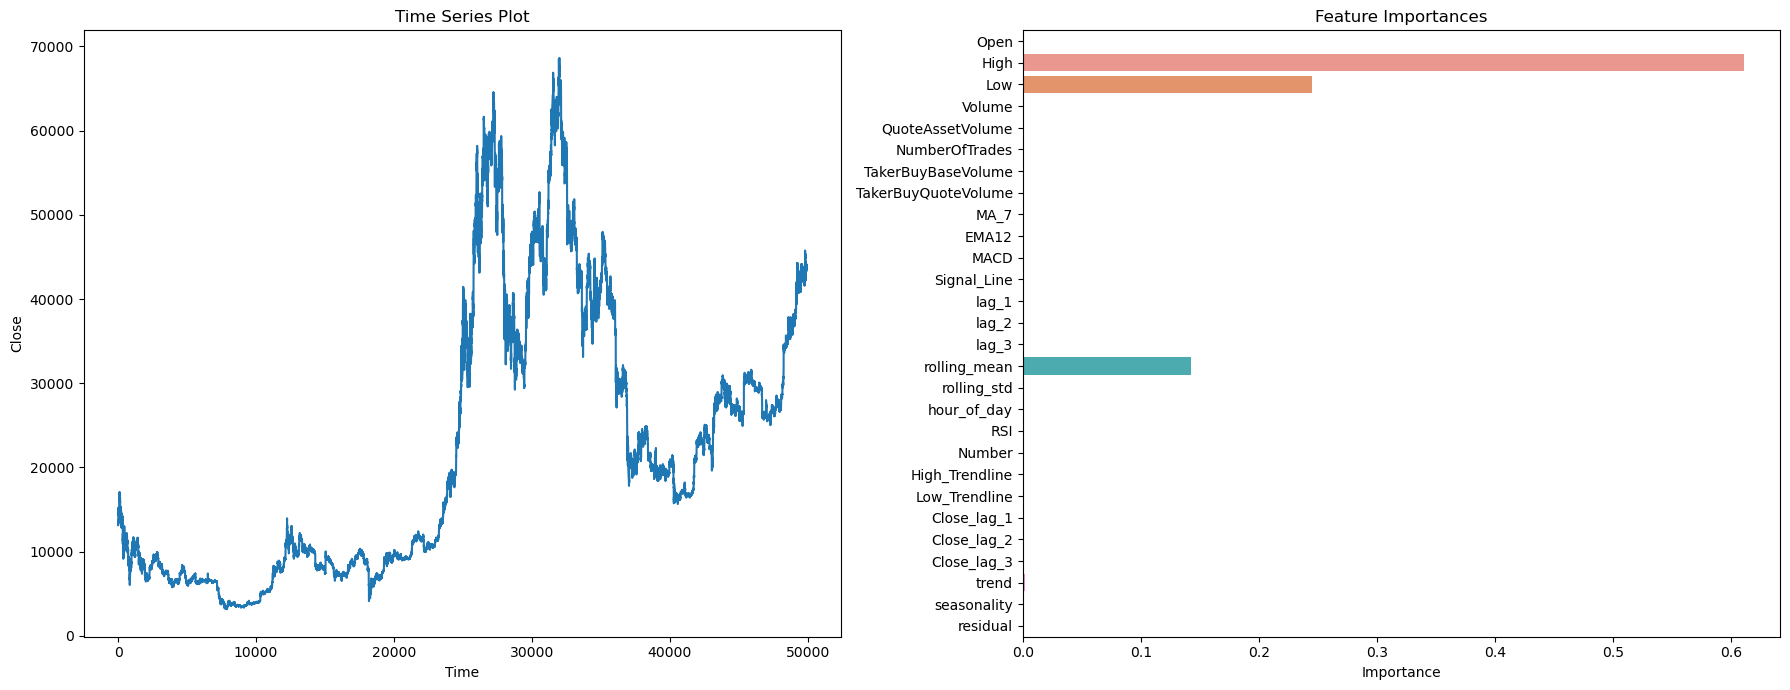

['Open', 'High', 'Low', 'Volume', 'QuoteAssetVolume', 'NumberOfTrades', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'MA_7', 'EMA12', 'MACD', 'Signal_Line', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std', 'hour_of_day', 'RSI', 'Number', 'High_Trendline', 'Low_Trendline', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'trend', 'seasonality', 'residual']
Time Series Feature Selection Analysis:
---------------------------------------

Total Features Selected: 28

Feature: Open, Importance: 5.883423325003375e-06
Feature: High, Importance: 0.6110767386665453
Feature: Low, Importance: 0.24501287537016062
Feature: Volume, Importance: 6.607930915961125e-07
Feature: QuoteAssetVolume, Importance: 6.208724955043466e-07
Feature: NumberOfTrades, Importance: 9.441342159879737e-07
Feature: TakerBuyBaseVolume, Importance: 7.71019070233988e-07
Feature: TakerBuyQuoteVolume, Importance: 7.266449854603417e-07
Feature: MA_7, Importance: 7.449176695718434e-07
Feature: EMA12, Importance: 5.2304747058

In [57]:
df_clean, features_selected, analysis_explanation = alpha_Feat_Selector(df_raw, 'cleaned_data.csv', 'Close', importance_percentile=20)

# print(df_clean.head(1)) # Check the cleaned dataframe 
print(features_selected) # Check the selected features 
print(analysis_explanation) # Check the analysis explanation Des-Tri-Ct6-969-969-969